<a href="https://colab.research.google.com/github/nahuelalmeira/graphMachineLearning/blob/main/notebooks/PyTorch_Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 5 


## Generamos el word2vec con Pytorch

### Configuración general

In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 6.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 9.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 7.4 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 9.4 MB/s 
     |████████████████████████████████| 325 kB 8.9 MB/s 
     |████████████████████████████████| 407 kB 52.1 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=6e9dc9c3a08fc520c4c79be6c8e3967fe0069d35826b6d3c246cca2356a217aa
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built to

In [2]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [13]:
!pip install igraph

     |████████████████████████████████| 3.2 MB 8.9 MB/s 


### Importamos las librerias necesarias

In [16]:
import numpy as np
import networkx as nx
import pandas as pd

from torch_geometric.nn import Node2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')


import networkx as nx
import igraph 
from igraph import Graph
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Agregamos nuestro grafo generado en los anteriores puntos

Importamos los datasets

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
def connect_to_drive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)  
  return pd.read_csv(filename)

drive = connect_to_drive() 


In [4]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}


In [17]:
df = read_csv_from_drive(drive, '1ecOBly_KJp5GCDOOE3_Rs8F3L3p_QJRk', 'vacunas.csv').dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1.362962e+18,2.737379e+09,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1.364001e+18,2.521681e+08,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1.364001e+18,2.521681e+08,153663816,[],NaN


In [22]:
etiquetas = read_csv_from_drive(drive, '1qXme18gwQKQ-7N2BevqLf4jAKvH4utLG', 'etiquetas.csv')

Ahora creamos el grafo (de los trabajos anteriores)

In [24]:
dff = df[['user.id', 'user_retweeters']]
df_final = dff.explode('user_retweeters')
df_final = df_final.dropna()
df_final = pd.merge(df_final.reset_index(drop=True), etiquetas, on = "user.id", how = "left")
df_etiquetados = df_final.dropna().reset_index(drop=True)
edges = pd.DataFrame({"source": df_etiquetados['user.id'],
                      "target": df_etiquetados['user_retweeters']})
g = nx.from_pandas_edgelist(edges,
                            source='source', 
                            target='target')

In [27]:
edges

,source,target
0,252168075,1238117630696972289
1,252168075,37232479
2,252168075,1279224657124753408
3,252168075,1299172647583051777
4,252168075,920281298735976449
...,...,...
86516,484349869,1196548869619953671
86517,484349869,1193738128412102657
86518,484349869,315827796
86519,484349869,252168075


In [25]:
print(nx.info(g))

Graph with 17982 nodes and 22558 edges


In [26]:
n = g.number_of_nodes()
nodes = [v for v in g.nodes()]

## Matrices esparsas

Para hacer uso eficiente de la memoria, PyTorch-Geometric utiliza matrices esparsas. En particular usa el formato de coordenadas, o [COO](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)).

In [28]:
adj = nx.to_scipy_sparse_matrix(g).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

## Node2Vec

In [29]:
## Definimos nuestro modelo
model = Node2Vec(
    edge_index, embedding_dim=100, walk_length=10, 
    context_size=4, num_negative_samples=5
).to(device)

## El loader es un wrapper que nos permite trabajar por lotes, 
## para utilizar descenso por el gradiente estocástico y
## sus variantes
loader = model.loader(batch_size=128, shuffle=True)

## Optimizador
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

Definimos la función de entrenamiento

In [30]:
def train():
    ## Ponemos nuestro modelo en modo entrenamiento
    model.train()

    total_loss = 0
    for pos_rw, neg_rw in loader:

        ## Reseteamos los gradientes
        optimizer.zero_grad()

        ## Calculamos el error (la función de costo) del lote
        ## en función de los samples positivos y negativos
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))

        ## Hacemos backpropagation
        loss.backward()

        ## Avanzamos un paso
        optimizer.step()

        ## Actualizamos la función de costo total
        total_loss += loss.item()

    return total_loss / len(loader)

Entrenamos el modelo

In [31]:
epochs = 100
for epoch in range(epochs):
    loss = train()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3} - Loss: {loss:.3f}')

Epoch:   0 - Loss: 6.417
Epoch:   5 - Loss: 2.333
Epoch:  10 - Loss: 1.259
Epoch:  15 - Loss: 0.941
Epoch:  20 - Loss: 0.864
Epoch:  25 - Loss: 0.857
Epoch:  30 - Loss: 0.882
Epoch:  35 - Loss: 0.848
Epoch:  40 - Loss: 0.843
Epoch:  45 - Loss: 0.843
Epoch:  50 - Loss: 0.843
Epoch:  55 - Loss: 0.842
Epoch:  60 - Loss: 0.844
Epoch:  65 - Loss: 0.843
Epoch:  70 - Loss: 0.843
Epoch:  75 - Loss: 0.843
Epoch:  80 - Loss: 0.843
Epoch:  85 - Loss: 0.842
Epoch:  90 - Loss: 0.843
Epoch:  95 - Loss: 0.842


Obtenemos el embedding

In [32]:
def get_embedding():
    model.eval()
    with torch.no_grad():
        nodes = torch.arange(g.number_of_nodes(), device=device)
        embedding = model(nodes).detach().numpy()
    return embedding

embedding = get_embedding()

Reducimos la dimensión del embedding para poder graficar

In [33]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

### Necesitamos los labels para pintarlos en el embedding 

Importamos el dataset con los labels y las comunidades generadas


In [39]:
clasificacion_usuarios = pd.read_csv('https://raw.githubusercontent.com/data-datum/grafos/main/usuarios_clasificados.csv')

In [40]:
etiqueta_0 = [i for i, v in enumerate(G.nodes()) if v in (list(clasificacion_usuarios[clasificacion_usuarios['Clase']==0]['user.id']))]
etiqueta_1 = [i for i, v in enumerate(G.nodes()) if v in (list(clasificacion_usuarios[clasificacion_usuarios['Clase']==1]['user.id']))]

comunidad_0 = [i for i, v in enumerate(G.nodes()) if v in (list(clasificacion_usuarios[clasificacion_usuarios['grupo']==0]['user.id']))] 
comunidad_1 = [i for i, v in enumerate(G.nodes()) if v in (list(clasificacion_usuarios[clasificacion_usuarios['grupo']==1]['user.id']))]

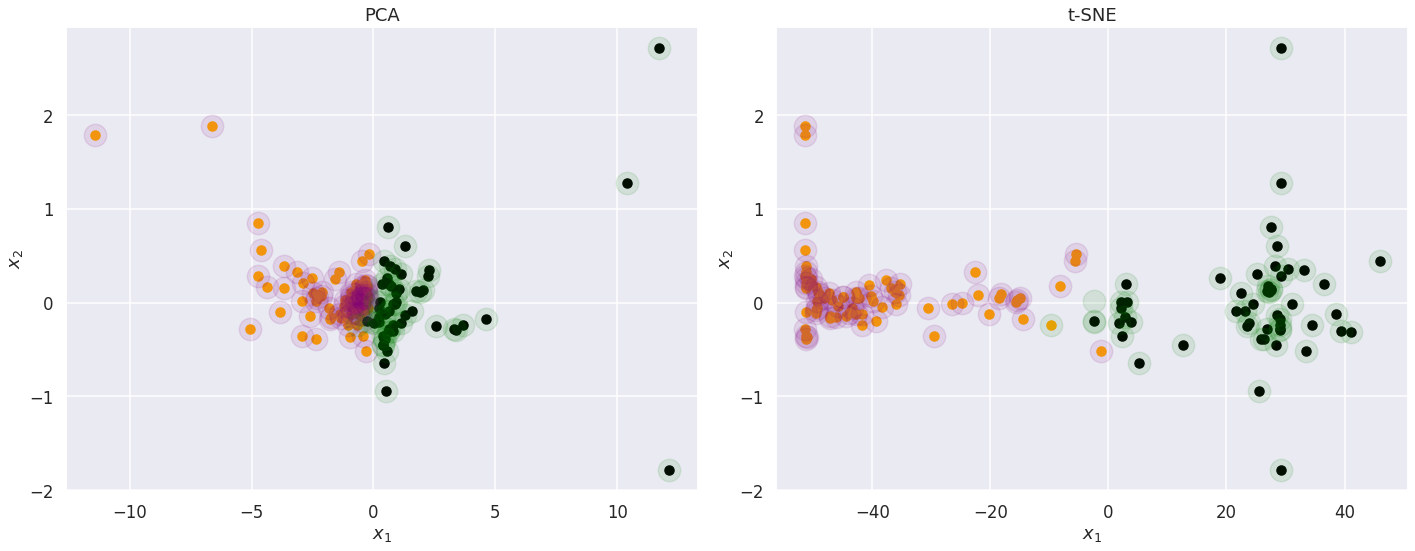

In [48]:
def add_labels(g, pos, ax):
    labels = [v for v in g.nodes()]
    for i in range(g.number_of_nodes()):
        x, y = pos[i]
        label = labels[i]
        ax.text(x, y, label)


fig, axes = plt.subplots(figsize=(20, 8), ncols=2)

ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

ax.set_title('PCA')
x, y = pca[comunidad_1][:,0],pca[comunidad_1][:,1]
ax.scatter(x,y, c='orange')
x, y = pca[comunidad_0][:,0],pca[comunidad_0][:,1]
ax.scatter(x,y, c='black')
x, y = pca[etiqueta_0][:,0],pca[etiqueta_0][:,1]
ax.scatter(x,y, c='purple', alpha = 0.1, s=500)
x, y = pca[etiqueta_1][:,0],pca[etiqueta_1][:,1]
ax.scatter(x,y, c='green', alpha = 0.1, s=500)


ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
x, y = tsne[comunidad_1][:,0],pca[comunidad_1][:,1]
ax.scatter(x,y, c='orange')
x, y = tsne[comunidad_0][:,0],pca[comunidad_0][:,1]
ax.scatter(x,y, c='black')
x, y = tsne[etiqueta_0][:,0],pca[etiqueta_0][:,1]
ax.scatter(x,y, c='purple', alpha = 0.1, s=500)
x, y = tsne[etiqueta_1][:,0],pca[etiqueta_1][:,1]
ax.scatter(x,y, c='green', alpha = 0.1, s=500)

plt.tight_layout()
plt.show()

## Conclusión

Como podemos obsevar en la figura anterior, se visualizan los agrupamientos correspondientes a las dos clases / comunidades en estudio. 

Originalmente, teníamos las etiquetas correspondientes a dos grupos (0 y 1), y luego, habiamos detectado 4 comunidades. Al realizar la matriz de confusión veíamos que había una coincidencia casi 100% en todos los casos. 
Eso se observa y confirma en el gráfico anterior. 

Los puntos en el gráfico poseen una especie de contorno transparente que corresponde a la etiqueta original, y la parte llena del punto corresponde a la comunidad asignada. 

También sucede en muy pocos casos, que el contorno difiere del relleno del punto, dando a entender, que la comunidad asignada no es igual a la etiqueta original. Esto sucede en zonas en las que ambas comunidades están cercanas en el espacio. 


A su vez, en tSNE los puntos correspondientes a cada clase se encuentran más separados que en PCA. 